In [31]:
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen  # That is an useful package
from scipy.constants import c  # speed of light
from scipy.optimize import curve_fit
from scipy.stats import chisquare, chi2
from scipy.integrate import quad

# Define nice figure size for MatplotLib
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [5]:
SN_list = []
z_array = np.array([])
mod_array = np.array([])
moderr_array = np.array([])
f = urlopen("http://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt")
for line in f:
    pieces = line.decode("utf8").split("\n")
    # Header of data is commentd out, we do not need this
    # Data format is SN name, redshift, distance modulos, error
    # we read data from urlib.request line by line
    if "#" in pieces[0]:
        continue
    SN, z, mod, moderr, staterr = line.split()
    SN_list.append(SN)
    z_array = np.append(z_array, np.float64(z))
    mod_array = np.append(mod_array, np.float64(mod))
    moderr_array = np.append(moderr_array, np.float64(moderr))
f.close()  # Always close you IO channels.
dataRaw = np.vstack([z_array, mod_array, moderr_array]).T
dataRaw = dataRaw[dataRaw[:, 0].argsort()]
zz = dataRaw[:, 0]
mu = dataRaw[:, 1]
mu_err = dataRaw[:, 2]
ZLIM = np.max(zz)

In [6]:
def distanceMPc():
        """"Calculate Luminosity distance from distance modules
        UNITs: MegaParsec
        """
        luminosityDistance = 0.00001 * 10 ** (mu / 5)
        distanceError = luminosityDistance * np.log(10) * mu_err
        return luminosityDistance, distanceError


In [7]:
def dataToZ(*args):
        """"Filter data to z given in argument.
        If none is given, all data is returned.
        """
        if len(args) != 0:
            ZMAX = args[0]
            indx = np.where(zz < ZMAX)
            zfilter = zz[indx]
            mufilter = mu[indx]
            mufilterError = mu_err[indx]
            dist, distError = distanceMPc()
            dfilter = dist[indx]
            dfilterError = distError[indx]
        else:
            zfilter = zz
            mufilter = mu
            mufilterError = mu_err
            dist, distError = distanceMPc()
            dfilter = dist
            dfilterError = distError
        return zfilter, mufilter, mufilterError, dfilter, dfilterError


In [8]:
def plotDataToZ(*args, **kwargs):
        """"Plot data Distance Modules x Z and Distance x z
        up to given z.
        z default to all data
        """
        if len(args) != 0:
            ZMAX = args[0]
            zfilter, mufilter, mufilterError, dfilter, dfilterError = dataToZ(ZMAX)
        else:
            zfilter, mufilter, mufilterError, dfilter, dfilterError = dataToZ()

        fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)
        ax1.errorbar(
            zfilter,
            mufilter,
            yerr=mufilterError,
            fmt=".",
            capsize=0,
            elinewidth=1.0,
            ecolor=(0.6, 0.0, 1.0),
            color="green",
        )
        ax1.set_xlabel(r"$z$", fontsize=20)
        ax1.set_ylabel(r"$\mu$", fontsize=20)
        ax1.grid(b=True, which="both")
        ax1.set_title("Distance Modulus")
        ax2.errorbar(
            zfilter,
            dfilter,
            yerr=dfilterError,
            fmt=".",
            ecolor=(0.6, 0.0, 1.0),
            color="green",
            label="dataSN",
        )
        ax2.set_xlabel("redshift z")
        ax2.set_ylabel("Distance (Mpc)")
        ax2.set_ylim(bottom=0)
        ax2.grid(b=True, which="both")
        ax2.legend(loc="upper left")
        ax2.set_title("Luminosity Distance")
        return ax1, ax2

In [9]:
def hubbleDiagram(self, *args):
        """"Plot Hubble diagram in terms of velocity and distance
        up to a given z.
        """
        if len(args) != 0:
            ZMAX = args[0]
            zfilter, mufilter, mufilterError, dfilter, dfilterError = self.dataToZ(ZMAX)
        else:
            zfilter, mufilter, mufilterError, dfilter, dfilterError = self.dataToZ()

        vel = c * zfilter / 1000  # velocity in km/s
        fig, ax = plt.subplots(constrained_layout=True)
        ax.errorbar(dfilter, vel, xerr=dfilterError, fmt=".")
        ax.set_xlabel("D(Mpc)")
        ax.set_ylabel("Velocity (Km/s)")
        ax.set_xlim(left=0)
        ax.grid(b=True, which="both")
        ax.set_title("Hubble relations, data from Supernova Cosmology Probe")
        sec = ax.secondary_yaxis(
            "right", functions=(lambda x: 1000 * x / c, lambda x: c * x / 1000)
        )
        sec.set_ylabel("z")
        return

In [ ]:
def dHubble(z, H0):
        return (1 / 1000) * c * z / H0

def muHubble(z, H0):
    return 5 * np.log10(10 ** 6 * dHubble(z, H0)) - 5

def dQ(z, H0, q):
    return (1 / 1000) * (c * z / H0) * (1 - (1 + q) * z / 2)

def muQ(z, H0, q):
    return 5 * np.log10(10 ** 6 * dQ(z, H0, q)) - 5

In [23]:
## Voce tem que mudar aqui!
def dFRW(z, H0, OmM):
    def EE(z, H0, OmM):
        OmL = 1 - OmM
        return 1 / np.sqrt(OmM * (1 + z) ** 3 + OmL)

    tmp = quad(EE, 0, z, args=(H0, OmM))[0]
    dL = ((1 + z) * c / (1000 * H0)) * tmp
    return dL

In [43]:
zz.T

array([0.015     , 0.015     , 0.015     , 0.01502704, 0.0151    ,
       0.015166  , 0.0152    , 0.0152    , 0.0153    , 0.0154363 ,
       0.016     , 0.016     , 0.0163    , 0.016321  , 0.01634564,
       0.01645   , 0.016559  , 0.01673   , 0.016743  , 0.016991  ,
       0.017173  , 0.017227  , 0.0173    , 0.0173    , 0.017605  ,
       0.01793128, 0.01831523, 0.0187    , 0.0189    , 0.0192    ,
       0.0192    , 0.019264  , 0.0195    , 0.019599  , 0.02037472,
       0.0205    , 0.0208    , 0.0209    , 0.0211    , 0.0212    ,
       0.0215    , 0.021793  , 0.0219    , 0.02198001, 0.0221    ,
       0.0221    , 0.0224    , 0.0229    , 0.0229    , 0.02297117,
       0.023     , 0.023208  , 0.0233    , 0.0233    , 0.023536  ,
       0.0239    , 0.023953  , 0.024     , 0.0241853 , 0.0242    ,
       0.024314  , 0.024525  , 0.0247    , 0.0248    , 0.0249    ,
       0.0251    , 0.0255    , 0.0256    , 0.0259    , 0.026     ,
       0.026038  , 0.0261    , 0.026489  , 0.0266    , 0.02680

In [65]:
## Faça testes
def EE(z, H0, OmM):
        OmL = 1 - OmM
        return 1 / np.sqrt(OmM * (1 + z) ** 3 + OmL)
## Veja EE é vetorizada
print(zz.shape)
EE(zz,70,0.3)
########################
## Isto dá errado!)
#quad(EE,0,zz,args=(70,0.3))
## Isto dá certo
quad(EE,0,zz[9],args=(70,0.3))
# O resultado é um valor da integral e um erro, pegamos só o valor da integral
quad(EE,0,0.8,args=(70,0.3))[0]
## ODEINT
### Precisa de uma função com os parametros certos, tem que incluir uma variável
def EEy(y, z, H0, OmM):
        OmL = 1 - OmM
        return 1 / np.sqrt(OmM * (1 + z) ** 3 + OmL)

## Tem que definir condição inicial.
from scipy.integrate import odeint
zz = np.insert(zz, 0, 0.)
odeint(EEy,0,zz,args=(70,0.3))


(583,)


(0.015147847864590456, 1.6817489472787334e-16)

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.0149492 ],
       [0.0149492 ],
       [0.0149492 ],
       [0.01497606],
       [0.01504852],
       [0.01511407],
       [0.01514784],
       [0.01514784],
       [0.01524715],
       [0.0153825 ],
       [0.01594219],
       [0.01594219],
       [0.01624   ],
       [0.01626084],
       [0.0162853 ],
       [0.01638889],
       [0.01649707],
       [0.01666679],
       [0.01667969],
       [0.01692579],
       [0.01710639],
       [0.01715997],
       [0.0172324 ],
       [0.0172324 ],
       [0.01753499],
       [0.01785865],
       [0.01823945],
       [0.01862099],
       [0.01881929],
       [0.0191167 ],
       [0.0191167 ],
       [0.01918015],
       [0.01941408],
       [0.0195122 ],
       [0.0202809 ],
       [0.02040502],
       [0.02070221],
       [0.02080127],
       [0.02099937],
       [0.02109841],
       [0.02139551],
       [0.02168564],
       [0.02179158],
       [0.021

In [ ]:
## Você tem que mudar aqui! A função é lenta por causa deste for.
## dFRW esta calculando um valor de z por vez. 
## Quando voce utilizar a função odeint ela vai calcular todos os valor de z de 
## uma vez só e o for abaixo não vai ser necessário
def muFRW(z, H0, OmM):
    DL = np.array([])
    for ZZ in z:
        tmp = dFRW(ZZ, H0, OmM)
        DL = np.append(DL, np.float64(tmp))
    return 5 * np.log10(10 ** 6 * DL) - 5

In [24]:
def chiSq(x, y, err):
    return np.sum(((x - y) / err) ** 2)

def fitDataMu(**kwargs):
        # parse arguments
        ZMAX = kwargs.get("ZMAX")
        FIT = kwargs.get("FIT")
        if ZMAX == None:
            zfilter, mufilter, mufilterError, dfilter, dfilterError = dataToZ()
        else:
            zfilter, mufilter, mufilterError, dfilter, dfilterError = dataToZ(ZMAX)
        fits = ("HUBBLE", "QUADRATIC")
        try:
            if FIT == "HUBBLE":
                func = muHubble
                INICIAL = 68
                BOUNDS = ([0], [100])
            elif FIT == "QUADRATIC":
                func = muQ
                INICIAL = (68, 0)
                BOUNDS = ([65, -5], [75, 5])
            elif FIT == "FRW":
                func = muFRW
                INICIAL = (68, 0.3)
                BOUNDS = ([65, 0], [75, 1])
            else:
                raise ValueError("Not a valid fit type: try HUBBLE or QUADRATIC")
        except ValueError as err:
            print(err.args)
        popt, pcov = curve_fit(
            func, zfilter, mufilter, sigma=mufilterError, p0=INICIAL, bounds=BOUNDS
        )
        perr = np.sqrt(np.diag(pcov))
        CHI2 = chiSq(mufilter, func(zfilter, *popt), mufilterError)
        dof = len(zfilter) - len(popt) - 1
        CHI2reduced = CHI2 / dof
        pvalue = chi2.sf(CHI2, dof)
        return popt, perr, CHI2reduced, pvalue


In [25]:
def plotFitZ(*args):
        """" Plot data Distance Modules x Z and Fitted Curves
        ZMAX default to all values
        Argument should be a float or None.
        """
        # Filter data
        if len(args) != 0:
            ZMAX = args[0]
            zfilter, mufilter, mufilterError, dfilter, dfilterError = dataToZ(ZMAX)
        else:
            zfilter, mufilter, mufilterError, dfilter, dfilterError = dataToZ()
            ZMAX = ZLIM
        # Fit the data
        HUBBLE = fitDataMu(FIT="HUBBLE", ZMAX=ZMAX)
        QUADRATIC = fitDataMu(FIT="QUADRATIC", ZMAX=ZMAX)
        FRW = fitDataMu(FIT="FRW", ZMAX=ZMAX)
        # Compute fitted values
        zrange = np.linspace(0.001, ZMAX, 200)
        fitHubbleMU = muHubble(zrange, *HUBBLE[0])
        fitQMU = muQ(zrange, *QUADRATIC[0])
        fitFRWMU = muFRW(zrange, *FRW[0])

        fig, ax = plt.subplots(constrained_layout=True)
        # Plot DATA with Errorbars
        ax.errorbar(
            zfilter,
            mufilter,
            yerr=mufilterError,
            fmt=".",
            capsize=0,
            elinewidth=1.0,
            ecolor=(0.6, 0.0, 1.0),
            color="green",
            label="SN UNION2.1 Data",
        )
        ax.set_xlabel(r"$z$", fontsize=20)
        ax.set_ylabel(r"$\mu$", fontsize=20)
        # Plot fitted functions
        ax.plot(zrange, fitHubbleMU, label="Hubble Law")
        ax.plot(zrange, fitQMU, label="Quadratic")
        ax.plot(zrange, fitFRWMU, label="Flat FRW")
        ax.grid(b=True, which="both")
        ax.legend(loc="lower right")
        ax.set_title("Supernova Data and Fits")
        return

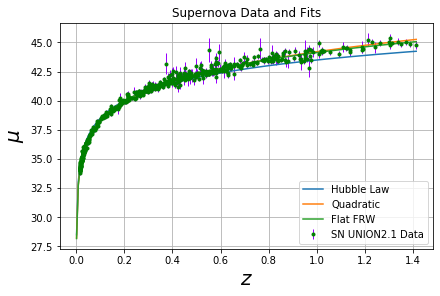

In [26]:
plotFitZ()